# GAN

In [7]:
import numpy as np
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler
from sklearn.exceptions import ConvergenceWarning # Import ConvergenceWarning
import warnings
import matplotlib.pyplot as plt
import pickle

# Filter convergence warnings
warnings.filterwarnings('ignore')

In [2]:
# Reading data
df = pd.read_excel('updated_DATASET.xlsx', engine="openpyxl")
df.info()

data = df.values # Convert dataframe to numpy array for processing

# Normalize or standardize your data (recommended for GANs)
scaler = StandardScaler()
data_scaled = scaler.fit_transform(data)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 80 entries, 0 to 79
Data columns (total 28 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   TemP (K)             80 non-null     int64  
 1   Time (min)           80 non-null     float64
 2   PS (mm)              80 non-null     float64
 3   BET (m2/g)           80 non-null     float64
 4   PV (cm3)             80 non-null     float64
 5   C (wt.%)             80 non-null     float64
 6   H  (wt.%)            80 non-null     float64
 7   N  (wt.%)            80 non-null     float64
 8   O  (wt.%)            80 non-null     float64
 9   Qm (mg/g)            80 non-null     float64
 10  TP_Benzocaine        80 non-null     int64  
 11  TP_Ciprofloxacin     80 non-null     int64  
 12  TP_Citalopram        80 non-null     int64  
 13  TP_Diclofenac        80 non-null     int64  
 14  TP_Dimetridazole     80 non-null     int64  
 15  TP_Floxentine        80 non-null     int64

In [3]:
# Parameters for the GAN
input_dim = data_scaled.shape[1]  # Number of features in your dataset
latent_dim = 100  # Dimension of the latent space
learning_rate = 0.0002  # Learning rate for the optimizers

In [4]:
# Generator Model
def build_generator():
    model = Sequential()
    model.add(Dense(128, input_dim=latent_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(BatchNormalization())
    model.add(Dense(input_dim, activation='tanh'))
    return model

# Discriminator Model
def build_discriminator():
    model = Sequential()
    model.add(Dense(128, input_dim=input_dim))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dense(1, activation='sigmoid'))
    return model

# GAN Model
def build_gan(generator, discriminator):
    model = Sequential()
    model.add(generator)
    model.add(discriminator)
    return model

# Create and compile models
generator = build_generator()
discriminator = build_discriminator()

# Compile discriminator with learning rate
discriminator_optimizer = Adam(learning_rate=learning_rate)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Create and compile GAN
gan = build_gan(generator, discriminator)
gan_optimizer = Adam(learning_rate=learning_rate)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

In [5]:
# Initialize lists to store metrics
d_losses = []
d_accuracies = []
g_losses = []

# Training function
def train_gan(epochs, batch_size=128):
    for epoch in range(epochs):
        # Train Discriminator
        idx = np.random.randint(0, data_scaled.shape[0], batch_size)
        real_samples = data_scaled[idx]
        fake_samples = generator.predict(np.random.randn(batch_size, latent_dim))
        d_loss_real = discriminator.train_on_batch(real_samples, np.ones((batch_size, 1)))
        d_loss_fake = discriminator.train_on_batch(fake_samples, np.zeros((batch_size, 1)))
        d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

        # Train Generator
        g_loss = gan.train_on_batch(np.random.randn(batch_size, latent_dim), np.ones((batch_size, 1)))

        # Store metrics
        d_losses.append(d_loss[0])
        d_accuracies.append(100 * d_loss[1])
        g_losses.append(g_loss)

        # Print progress
        if (epoch + 1) % 100 == 0:
            print(f'Epoch {epoch + 1}/{epochs} | D Loss: {d_loss[0]} | D Accuracy: {100*d_loss[1]} | G Loss: {g_loss}')

# Train the GAN
train_gan(epochs=10000, batch_size=64)

# Convert metrics to DataFrame
metrics_df = pd.DataFrame({
    'Epoch': range(1, len(d_losses) + 1),
    'D Loss': d_losses,
    'D Accuracy': d_accuracies,
    'G Loss': g_losses
})

# Save the metrics to a CSV file
metrics_df.to_csv('gan_metrics.csv', index=False)


2/2 [==============================] - 0s 2ms/step
Epoch 100/10000 | D Loss: 0.7004026770591736 | D Accuracy: 48.4375 | G Loss: 0.37662172317504883
2/2 [==============================] - 0s 2ms/step
Epoch 200/10000 | D Loss: 0.8238704353570938 | D Accuracy: 49.21875 | G Loss: 0.2770763039588928
2/2 [==============================] - 0s 1ms/step
Epoch 300/10000 | D Loss: 0.8352642357349396 | D Accuracy: 50.0 | G Loss: 0.27705809473991394
2/2 [==============================] - 0s 1ms/step
Epoch 400/10000 | D Loss: 0.8427040576934814 | D Accuracy: 50.0 | G Loss: 0.29090389609336853
2/2 [==============================] - 0s 1ms/step
Epoch 500/10000 | D Loss: 0.8316231295466423 | D Accuracy: 50.0 | G Loss: 0.2781320810317993
2/2 [==============================] - 0s 2ms/step
Epoch 600/10000 | D Loss: 0.8307053297758102 | D Accuracy: 50.0 | G Loss: 0.2872348427772522
2/2 [==============================] - 0s 1ms/step
Epoch 700/10000 | D Loss: 0.8292769640684128 | D Accuracy: 50.0 | G Loss: 0

In [5]:
# Generate new samples
num_samples = 100000
noise = np.random.randn(num_samples, latent_dim)
generated_samples = generator.predict(noise)

# Inverse transform to original scale
generated_samples_original = scaler.inverse_transform(generated_samples)

# Convert to DataFrame if needed
generated_df = pd.DataFrame(generated_samples_original, columns=df.columns)

3125/3125 [==============================] - 2s 691us/step


In [6]:
# Save the generated data to a CSV file
generated_df.to_csv('generated_samples.csv', index=False)

In [10]:
# Save the trained generator
pickle.dump(generator, open("gan_generator", "wb"))

In [5]:
# Load GAN metrics
file_path = 'gan_metrics.csv'
gan_metrics_df = pd.read_csv(file_path)

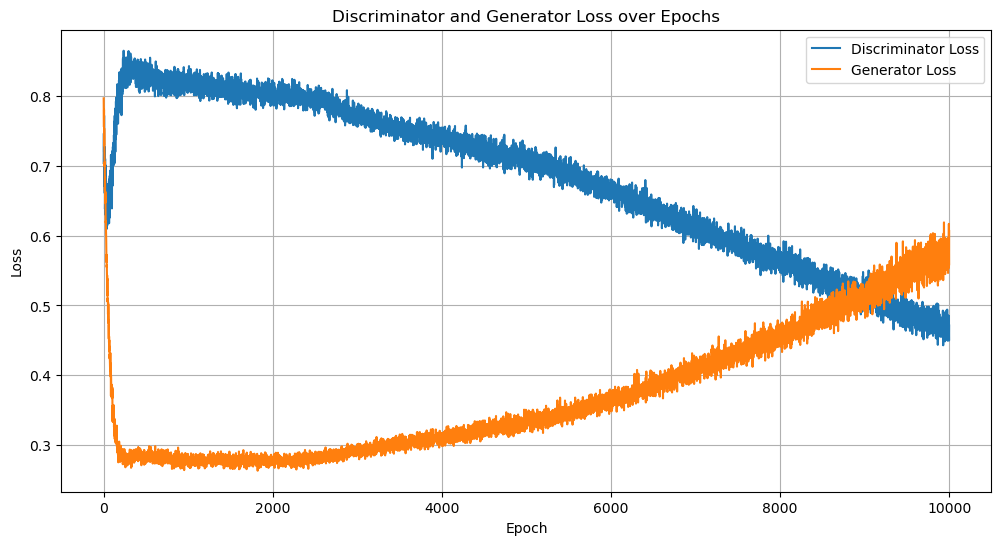

In [8]:
# Plotting Discriminator and Generator Loss over Epochs
plt.figure(figsize=(12, 6))
plt.plot(gan_metrics_df['Epoch'], gan_metrics_df['D Loss'], label='Discriminator Loss')
plt.plot(gan_metrics_df['Epoch'], gan_metrics_df['G Loss'], label='Generator Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Discriminator and Generator Loss over Epochs')
plt.legend()
plt.grid(True)
plt.savefig("GAN_training.png")
plt.show()